This notebook was made to check that the results from my fall velocity code agreed with that from Frances Beckett and the Met Office.  Initially, my numbers were totally different.  This turned out to be because I was using the particle density in place of the air density in my Reynolds number calculation.  On fixing this, the numbers are much closer, although they still don't agree perfectly.  This may be due to slightly different co-efficients (because of typos).  However, my numbers do agree with Liz Watson's implementation of the code in Python.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import os
os.chdir('/home/jsteven5/Modelling/Pankhurst_XMT/ash_settling_XMT/src/')
from travdist import atmos
from travdist import fall_velocity
import importlib
importlib.reload(atmos)
importlib.reload(fall_velocity)

<module 'travdist.fall_velocity' from '/home/jsteven5/Modelling/Pankhurst_XMT/ash_settling_XMT/src/travdist/fall_velocity.py'>

# Comparison of JAS Python code with FMB Fortran

The aim of the notebook is to reproduce the results shown in Figure 5 of Beckett et al. (2015) _Sensitivity of dispersion model forecasts..._ using Python code.  The Python code is to be used in papers by Liz Watson and by Matt Pankhurst, which are looking at tephrochronology and 3D ash particle shapes.  Reproducing the results is a check on the Python code.

Figure 5 graphs Fall Velocity ($m s^{-1}$) against particle diameter ($\mu m$).  It assumes the following:

+  Particle density: $2300~kg~m^{-3}$
+  Amospheric density: $1.2~kg~m^{-3}$
+  Atmospheric viscosity: $1.82 \times 10^{-5}~Pa~s$
+  Sphericity: $0.4, 0.7$ and $1.0$



In [2]:
# Load Frances' data
sph1 = pd.read_csv('/home/jsteven5/Modelling/Pankhurst_XMT/ash_settling_XMT/from_frances/Ganser_wCCF_sph1_Constant_Corr.dat',
                   sep=' ',
                   names=['diameter', 'white_FMB'])
sph4 = pd.read_csv('/home/jsteven5/Modelling/Pankhurst_XMT/ash_settling_XMT/from_frances/Ganser_wCCF_sphp4_Constant_Corr.dat',
                   sep=' ',
                   names=['diameter', 'ganser_FMB_04'])

df = pd.merge(sph1, sph4, on='diameter')
df.set_index('diameter', inplace=True)

# Calculate my data
sizes = np.array(df.index * 1e-6)
df['white_JAS'] = pd.Series([fall_velocity.white(d,
                                                 density=2300,
                                                 atm_density=1.2,
                                                 atm_viscosity=1.82e-5
                                                 ) for d in sizes], index=df.index)
df['ganser_JAS_04'] = pd.Series([fall_velocity.ganser(d,
                                                      density=2300,
                                                      sphericity=0.4,
                                                      atm_density=1.2,
                                                      atm_viscosity=1.82e-5
                                                      ) for d in sizes], index=df.index)
df['ganser_JAS_07'] = pd.Series([fall_velocity.ganser(d,
                                                      density=2300,
                                                      sphericity=0.7,
                                                      atm_density=1.2,
                                                      atm_viscosity=1.82e-5
                                                      ) for d in sizes], index=df.index)
df['ganser_JAS_sphere'] = pd.Series([fall_velocity.ganser(d,
                                                      density=2300,
                                                      sphericity=1.0,
                                                      atm_density=1.2,
                                                      atm_viscosity=1.82e-5
                                                      ) for d in sizes], index=df.index)
df['stokes_JAS'] = pd.Series([fall_velocity.stokes(d,
                                                   density=2300,
                                                   atm_density=1.2,
                                                   atm_viscosity=1.82e-5
                                                   ) for d in sizes], index=df.index)

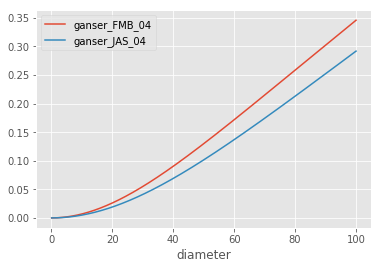

In [3]:
plt.close()
df[['ganser_FMB_04', 'ganser_JAS_04']].plot()
plt.savefig('Diameter_vs_fall_velocity_JAS.png')

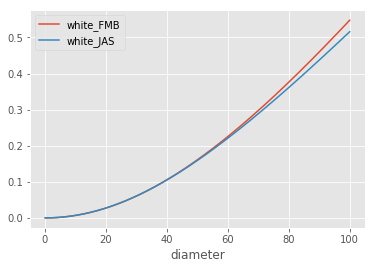

In [4]:
df[['white_FMB', 'white_JAS']].plot()

#### Liz Watson's implementation of France's Fortran code

In [5]:
# Define Ganser calculator function (Liz Watson's version)
import math
g = 9.80665
def ganser_velocity(diameter, density, air_density,sp, air_viscosity) :
    wt = (((diameter**2)/(18*air_viscosity))*g*(density-air_density))
    for i in range (0,50):#calculate reynolds number using stokes as initial first guess, break loop when converged
        re = (wt*diameter*air_density)/air_viscosity
        #ganser drag coefficient                         
        drag = (((24/(re*(3/(1+(2*(sp**-0.5))))))*(1+(0.1118*((re*((3/(1+(2*(sp**-0.5))))*(10**(1.8148*((-(math.log(sp,10)))**0.5743)))))**0.6567))))+((0.4305*(10**(1.8148*((-(math.log(sp,10)))**0.5743))))/(1+(3305/(re*(3/(1+(2*(sp**-0.5))))*(10**(1.8148*((-(math.log(sp,10)))**0.5743))))))))
        wt1 = (((4*(diameter)*g*(density-air_density))/(3*drag*air_density))**0.5)
        if abs (wt-wt1 < 0.000001):#keep going until convergence is reached max 50 iterations 
            break
        wt=wt1
    return wt

#df['ganser_LW'] = pd.Series([ganser_velocity(d, 2300, 1.225, 0.4, 1.7915e-5) for d in sizes], index=df.index)
df['ganser_LW_04'] = pd.Series([ganser_velocity(d, 2300, 1.2, 0.4, 1.82e-5) for d in sizes], index=df.index)

[]

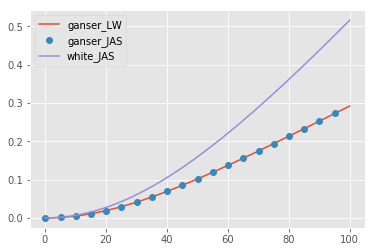

In [6]:
fig = plt.figure()
plt.plot(sizes*1e6, df.ganser_LW_04, label='ganser_LW')
plt.plot(df.index[::50], df.ganser_JAS_04[::50], 'o', label='ganser_JAS')
plt.plot(df.index, df.white_JAS, label='white_JAS')
plt.legend(loc='upper left')
plt.plot()

In [7]:
df.to_csv('Diameter_versus_Fall_Velocity_model_comparison.csv', index=False)
df[::100]

,white_FMB,ganser_FMB_04,white_JAS,ganser_JAS_04,ganser_JAS_07,ganser_JAS_sphere,stokes_JAS,ganser_LW_04
diameter,,,,,,,,
0.10000,0.000002,0.000002,6.881419e-07,5.842151e-07,6.473055e-07,6.881417e-07,6.881419e-07,6.881419e-07
10.10000,0.007115,0.007021,7.012729e-03,5.006614e-03,6.167925e-03,6.997425e-03,7.019735e-03,5.007389e-03
20.10004,0.027695,0.026375,2.758048e-02,1.925312e-02,2.394449e-02,2.745403e-02,2.780173e-02,1.925376e-02
30.10008,0.061025,0.055285,6.090492e-02,4.130841e-02,5.206885e-02,6.065869e-02,6.234667e-02,4.130894e-02
40.09996,0.106044,0.090740,1.055309e-01,6.940468e-02,8.884489e-02,1.055506e-01,1.106537e-01,6.940534e-02
50.09981,0.161471,0.130289,1.596527e-01,1.018671e-01,1.324877e-01,1.608517e-01,1.727230e-01,1.018678e-01
60.09966,0.225936,0.172210,2.214475e-01,1.373216e-01,1.813569e-01,2.251923e-01,2.485547e-01,1.373223e-01
70.09950,0.298077,0.215368,2.892783e-01,1.747306e-01,2.340697e-01,2.972142e-01,3.381488e-01,1.747314e-01
80.09935,0.376620,0.259047,3.617697e-01,2.133465e-01,2.895221e-01,3.756421e-01,4.415053e-01,2.133475e-01
